# Congenital Central Hypoventilation syndrome ("Ondine syndrome") from an existing set of genes

This notebook assumes that you have read **NORDic Network Identification (NI) Part I**. We consider here **NORDic version 2.2.1**.

## Installation

In [1]:
import NORDic

## Parameters for NORDic (from Part I)

In [2]:
file_folder="MODELS/Ondine_existing_genes/" ## the folder name is changed

Refer to Part I for further details.

In [3]:
## Registration to databases
DisGeNET_credentials = "../tests/credentials_DISGENET.txt"
STRING_credentials = "../tests/credentials_STRING.txt"
LINCS_credentials = "../tests/credentials_LINCS.txt"

## Parameters
seed_number=123456
from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2)
taxon_id=9606 # human species
disease_cids=["C1275808"] 
cell_lines=["NPC", "SHSY5Y"]

## Information about the disease
DISGENET_args = {
        "credentials": DisGeNET_credentials, "disease_cids": disease_cids,
}

## Selection of parameters relative to the prior knowledge network 
STRING_args = {
        "credentials": STRING_credentials, "score": 0,
}
EDGE_args = {
        "tau": 0, "filter": True, "connected": True, 
}

## Selection of parameters relative to experimental constraints
LINCS_args = {
        "path_to_lincs": "../lincs/", "credentials": LINCS_credentials,
        "cell_lines": cell_lines, "thres_iscale": None,
}
SIG_args = {
        "bin_thres": 0.5,
}

## Selection of parameters relative to the inference of networks
BONESIS_args = {
        "limit": 1, "exact": True, "max_maxclause": 3,
}

## Advanced
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

## Using a predetermined set of genes in NORDic

The network inferred in **NORDic Network Identification (NI) Part I** might not be very interesting, due to the small number of genes. **NORDic** allows feeding an existing network to the network identification pipeline, which means that the set of genes and/or a putative prior knowledge network are provided to the pipeline.

### A. Structure of a predetermined set of genes to **NORDic**

Any gene set in input to **NORDic** is a .TXT file where each row corresponds to a single gene.

In this example, we retrieve a set of interactions from the STRING database which involve at least one gene from the network inferred in **Part I**.

In [4]:
from NORDic.UTILS.STRING_utils import get_interactions_from_STRING

with open("MODELS/Ondine/solution.bnet", "r") as f:
    gene_list = [s.split(" <- ")[0] for s in f.read().split("\n")]
gene_list

['ASCL1', 'BDNF', 'EDN3', 'GDNF', 'PHOX2B']

In [5]:
from subprocess import call as sbcall
sbcall("mkdir -p "+file_folder, shell=True)

## Get physical interactions from the STRING database involving the list of genes in input
PPI = get_interactions_from_STRING(gene_list, taxon_id,
                                   min_score=0, app_name="NORDic_packagePartII",
                                   file_folder=file_folder)
PPI

<STRING> Retrieving the file from STRING... Saved at MODELS/Ondine_existing_genes/protein_action.tsv
<STRING> Getting the STRING name mapping for genes
<STRING> Getting the STRING name mapping for genes


,preferredName_A,preferredName_B,sign,directed,score
0,CX3CL1,BDNF,1,1,0.416
1,RANBP9,BDNF,2,0,0.416
2,UTS2,EDN3,2,1,0.902
4,GNA11,EDN3,2,1,0.900
5,GNA11,EDN3,2,0,0.900
...,...,...,...,...,...
1872,NTRK2,BDNF,1,0,0.814
1925,NTRK1,BDNF,1,0,0.800
1929,EDN3,CASR,2,0,0.905
1935,BDNF,NTRK1,1,0,0.800


In [6]:
## Get all genes in this PPI
genes = list(set(list(PPI["preferredName_A"])+list(PPI["preferredName_B"])))
## Save that list in a .TXT file
with open(file_folder+"genes.txt", "w") as f:
    f.write("\n".join(genes))
"%d genes" % len(genes)

'342 genes'

### B. Parameter finetuning

In [14]:
STRING_args.update({"score": 0.9})
EDGE_args.update({"tau": 0.3, "filter": True, "connected": True})
SIG_args.update({"bin_thres": 0.15})
LINCS_args.update({"thres_iscale": 0})
BONESIS_args.update({"limit": 200, "exact": False, "max_maxclause": 3})

## We use the set of genes defined above
path_to_genes = file_folder+"genes.txt"

### C. Network identification using a predetermined set of genes

In [15]:
from NORDic.NORDic_NI.functions import network_identification

larger_genes = network_identification(file_folder, taxon_id, 
            path_to_genes=path_to_genes, disgenet_args=DISGENET_args, 
            string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args,
            sig_args=SIG_args, bonesis_args=BONESIS_args, weights=DESIRABILITY,
            seed=seed_number, network_fname=None, njobs=njobs)

--- DATA IMPORT ---
1. Import gene set from MODELS/Ondine_existing_genes/genes.txt... ... 341 genes imported.
2. Import network from STRING... ... 13649 edges in model (including 0 directed edges) with a total of 341 non-isolated genes
3. Import experiments from LINCS L1000... 
	2 cell lines are considered (['NPC', 'SHSY5Y'])
	341 genes available (convertable to EntrezIDs)
		339/341 genes retrieved in LINCS L1000
... 284 genes in 119 profiles (17 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 10017 unique edges involving genes both in experiments (272 genes in total)
... score_STRING 0.900000	220 genes (non isolated in PPI)	3220 edges in PPI
2. Build topological constraints from filtered edges using gene expression data...  ...... 232 negative, 226 positive undirected interactions (458 edges in total), 220 non isolated genes in experiments
3. Build dynamical constraints by binarization of ex

  0%|                                                                                                                           | 0/1 [00:00<?, ?it/s]

Grounding...done in 0.9s
Found 200 solutions in 184.9s (first in 1.4s; rate 0.9s)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:07<00:00, 187.02s/it]


--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...200 solutions (200 unique solutions)
... 200 solutions (135/156 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 19 edges
<MODEL VISUALIZATION> Maximal solution: 102 edges
          1         2         3         4         5         6         7    \
GTP  0.760564  0.768685  0.758942  0.760204  0.756724  0.768685  0.760564   

          8         9         10        11        12        13       14   \
GTP  0.756725  0.757484  0.752347  0.756059  0.768685  0.756724  0.75606   

          15        16        17        18        19        20        21   \
GTP  0.755349  0.768685  0.760564  0.759331  0.768685  0.761754  0.768685   

          22        23        24       25        26        27        28   \
GTP  0.760564  0.768685  0.760564  0.74817  0.757633  0.758942  0.753922   

          29        30        31        32        33        34       35   \
GTP  0.759331  0.

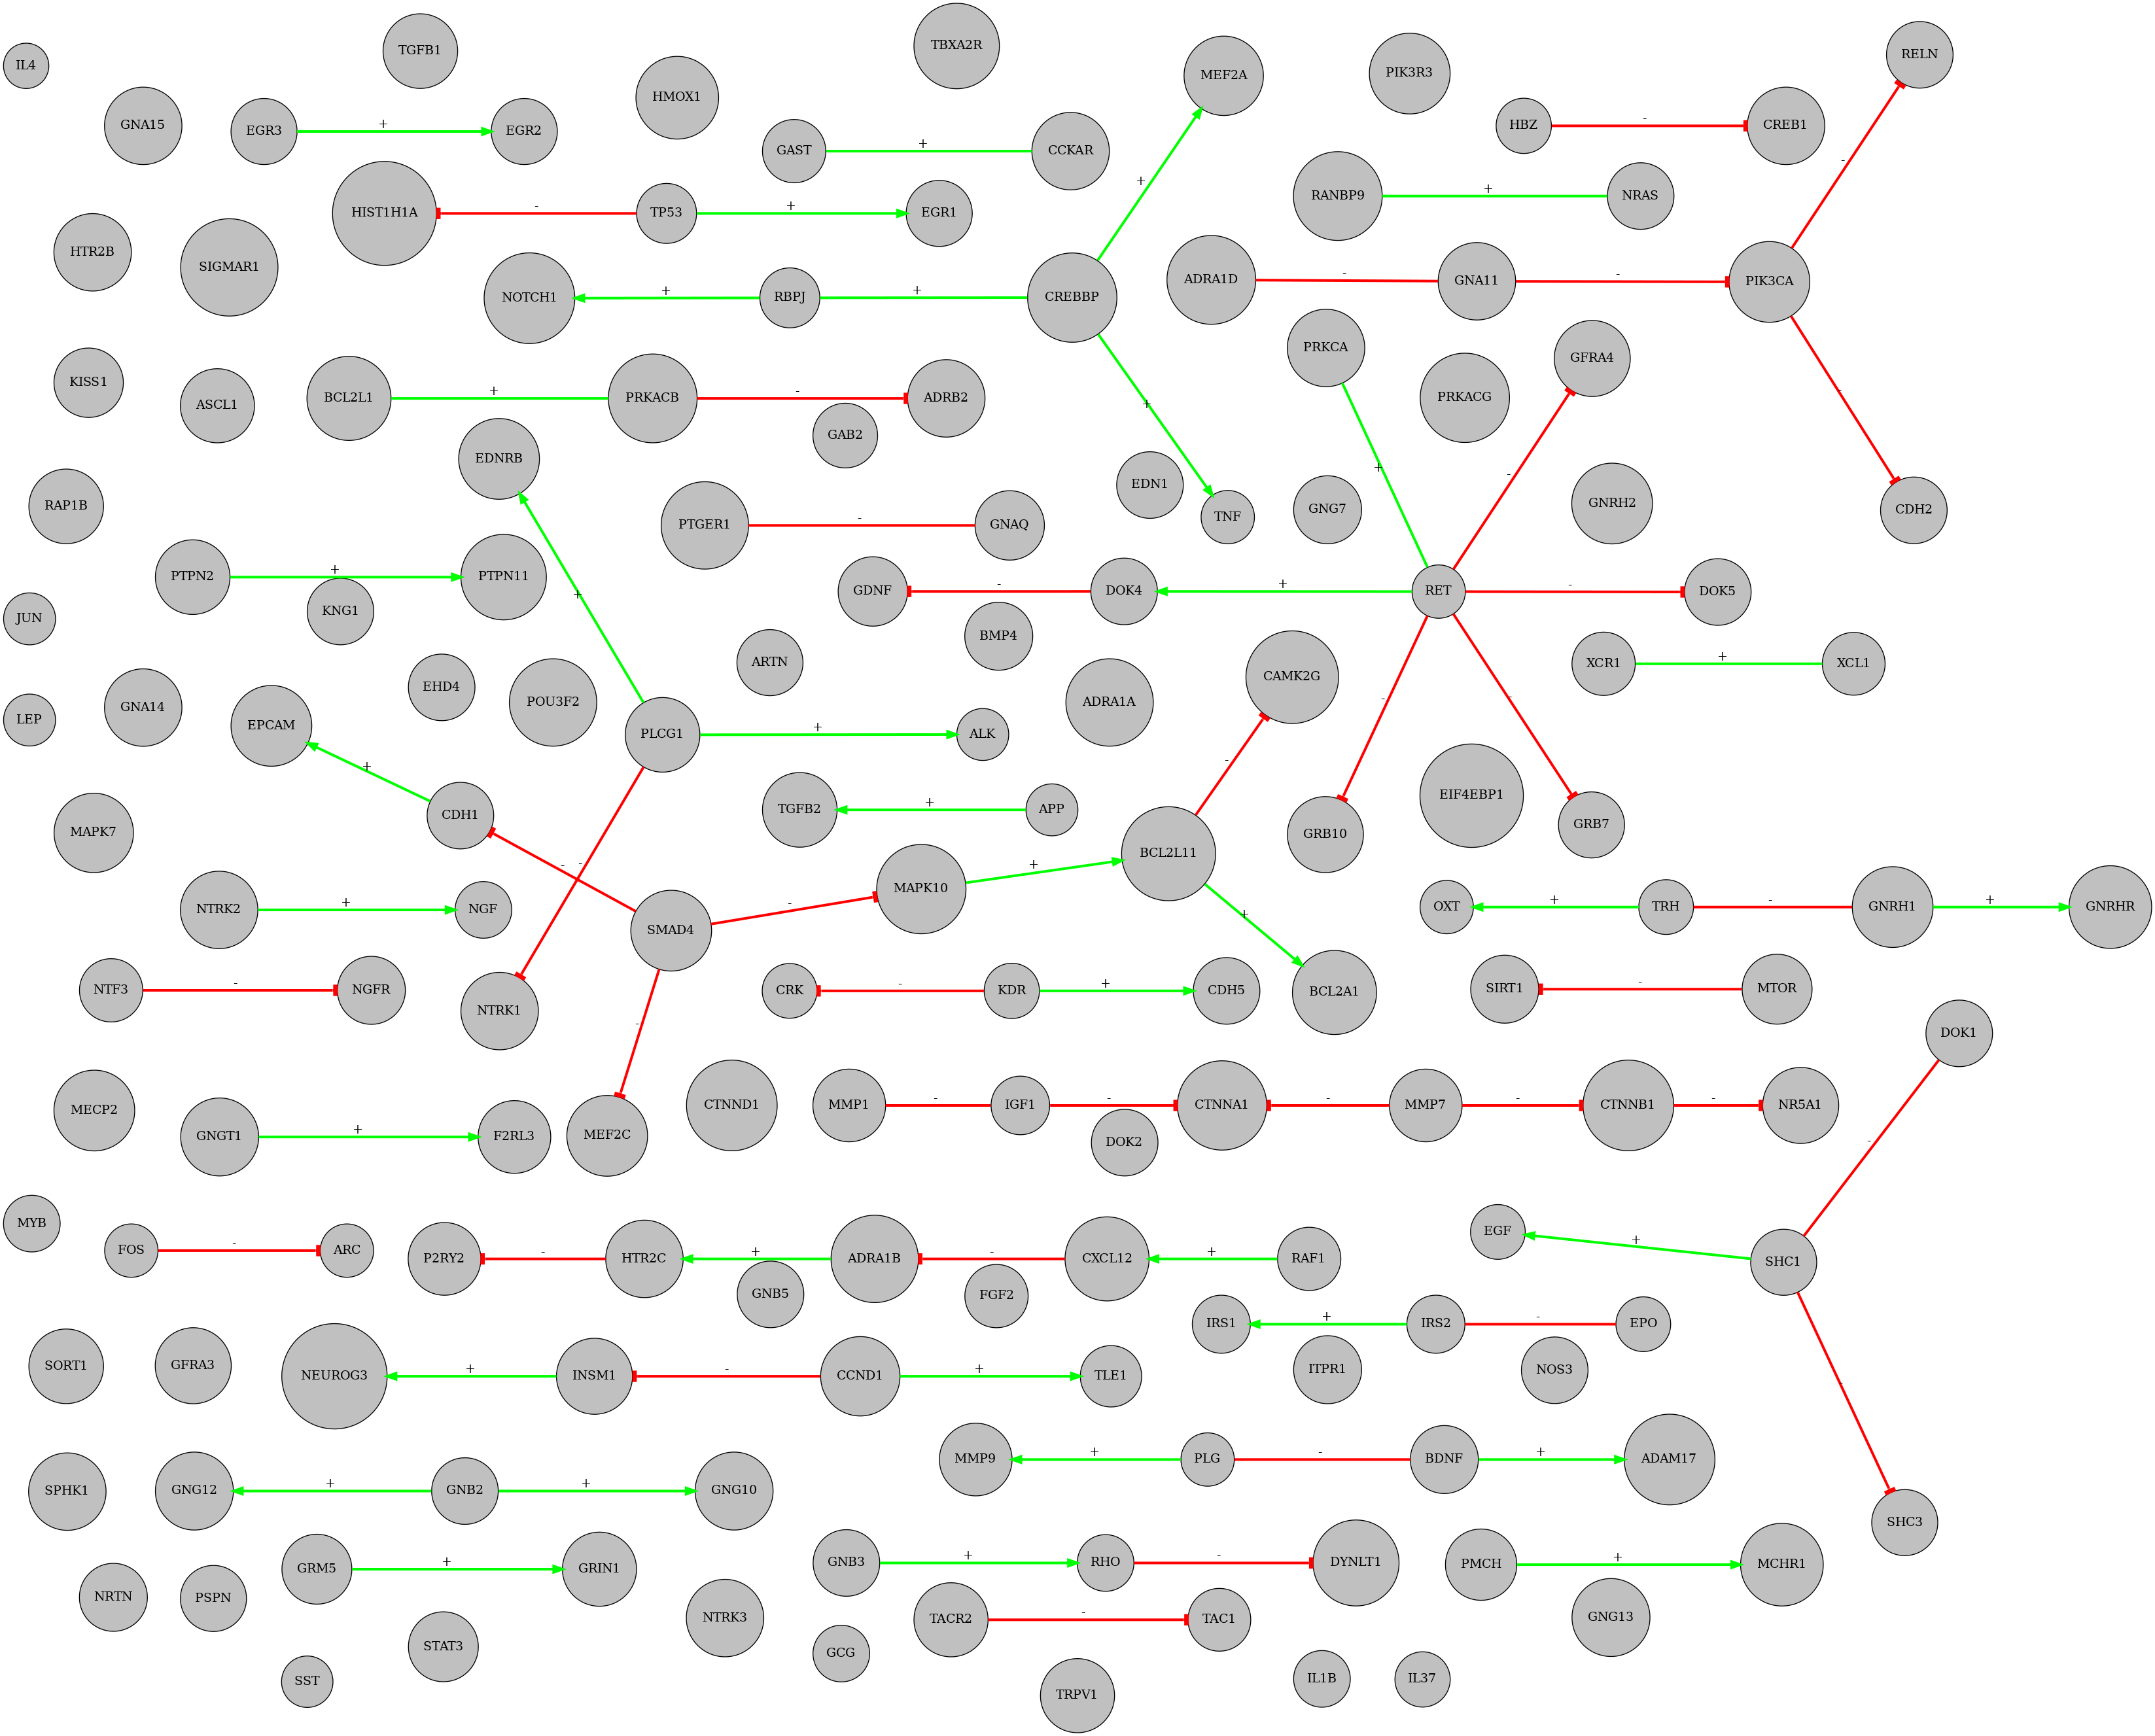

In [16]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 

### D. Conclusion

Note that **NORDic** can receive as inputs both a predetermined gene set (a value of *path_to_genes* not equal to None) and a pre-existing network (a value of *network_fname* not equal to None).